In [1]:
import sys, numpy as np
from argparse import ArgumentParser
from matplotlib import gridspec, pyplot as plt

from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm.querybuilder import QueryBuilder
from aiida.orm.data.structure import StructureData
from aiida.orm.data.parameter import ParameterData
from aiida.orm.calculation.job.quantumespresso.pw import PwCalculation
from aiida.orm.group import Group

In [2]:
def plot_results(query_res):
    """
    :param query_res: The result of an instance of the QueryBuilder
    """
    smearing_unit_set,magnetization_unit_set,pseudo_family_set = set(), set(), set()
    # Storing results:
    results_dict = {}
    for pseudo_family, formula, smearing, smearing_units, mag, mag_units in query_res:
        if formula not in results_dict:
            results_dict[formula] = {}
        # Storing the results:
        results_dict[formula][pseudo_family] = (smearing, mag)
        # Adding to the unit set:
        smearing_unit_set.add(smearing_units)
        magnetization_unit_set.add(mag_units)
        pseudo_family_set.add(pseudo_family)

    # Sorting by formula:
    sorted_results = sorted(results_dict.items())
    formula_list = zip(*sorted_results)[0]
    nr_of_results = len(formula_list)

    # Checks that I have not more than 3 pseudo families.
    # If more are needed, define more colors
    #pseudo_list = list(pseudo_family_set)
    if len(pseudo_family_set) > 3:
        raise Exception('I was expecting 3 or less pseudo families')

    colors = ['b', 'r', 'g']

    # Plotting:
    plt.clf()
    fig=plt.figure(figsize=(16, 9), facecolor='w', edgecolor=None)
    gs  = gridspec.GridSpec(2,1, hspace=0.01, left=0.1, right=0.94)

    # Defining barwidth
    barwidth = 1. / (len(pseudo_family_set)+1)
    offset = [-0.5+(0.5+n)*barwidth for n in range(len(pseudo_family_set))]
    # Axing labels with units:
    yaxis = ("Smearing energy [{}]".format(smearing_unit_set.pop()),
        "Total magnetization [{}]".format(magnetization_unit_set.pop()))
    # If more than one unit was specified, I will exit:
    if smearing_unit_set:
        raise Exception('Found different units for smearing')
    if magnetization_unit_set:
        raise Exception('Found different units for magnetization')
    
    # Making two plots, upper for the smearing, the lower for magnetization
    for index in range(2):
        ax=fig.add_subplot(gs[index])
        for i,pseudo_family in enumerate(pseudo_family_set):
            X = np.arange(nr_of_results)+offset[i]
            Y = np.array([thisres[1][pseudo_family][index] for thisres in sorted_results])
            ax.bar(X, Y,  width=0.2, facecolor=colors[i], edgecolor=colors[i], label=pseudo_family)
        ax.set_ylabel(yaxis[index], fontsize=14, labelpad=15*index+5)
        ax.set_xlim(-0.5, nr_of_results-0.5)
        ax.set_xticks(np.arange(nr_of_results))
        if index == 0:
            plt.setp(ax.get_yticklabels()[0], visible=False)
            ax.xaxis.tick_top()
            ax.legend(loc=3, prop={'size': 18})
        else:
            plt.setp(ax.get_yticklabels()[-1], visible=False)
        for i in range(0, nr_of_results, 2):
            ax.axvspan(i-0.5, i+0.5, facecolor='y', alpha=0.2)
        ax.set_xticklabels(list(formula_list),rotation=90, size=14, ha='center')
    plt.show()

In [3]:
def generate_query_graph(qh, out_file_name):

    def draw_vertice_settings(idx, vertice, **kwargs):
        """
        Returns a string with all infos needed in a .dot file  to define a node of a graph.
        :param node:
        :param kwargs: Additional key-value pairs to be added to the returned string
        :return: a string
        """
        if 'calculation' in vertice['type']:
            shape = "shape=polygon,sides=4"
        elif 'code' in vertice['type']:
            shape = "shape=diamond"
        else:
            shape = "shape=ellipse"
        filters = kwargs.pop('filters', None)
        additional_string = ""
        if filters:
            additional_string += '\nFilters:'
            for k,v in filters.items():
                additional_string += "\n   {} : {}".format(k,v)


        label_string = " ('{}')".format(vertice['tag'])

        labelstring = 'label="{} {}{}"'.format(
            vertice['type'], #.split('.')[-2] or 'Node',
            label_string,
            additional_string)
        #~ return "N{} [{},{}{}];".format(idx, shape, labelstring,
        return "{} [{},{}];".format(vertice['tag'], shape, labelstring)
    nodes = {v['tag']:draw_vertice_settings(idx, v, filters=qh['filters'][v['tag']]) for idx, v in enumerate(qh['path'])}
    links = [(v['tag'], v['joining_value'], v['joining_keyword']) for v in qh['path'][1:]]

    with open('temp.dot','w') as fout:
        fout.write("digraph G {\n")
        for l in links:
            fout.write('    {} -> {} [label=" {}"];\n'.format(*l))
        for _, n_values in nodes.items():
            fout.write("    {}\n".format(n_values))

        fout.write("}\n")
    import os
    os.system('dot temp.dot -Tpng -o {}'.format(out_file_name))

### Let's build up a graph query bit by bit

In [4]:
# Each group of calculations that are of interests has
# the string: group_basename+_+pseudo
# where pseudo is lda, pbe or pbesol
group_basename = 'tutorial_%'
# Instantiating QB:
qb = QueryBuilder()
# Appending the groups I care about:
qb.append(Group, filters={'name':{'like':group_basename}}, project='name', tag='group')
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query1.png') 

![Query graph](query1.png)

Append the calculations that are members of each group

In [5]:
qb.append(PwCalculation, tag='calculation', member_of='group')
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query2.png') 

![Query graph](query2.png)

Append the structures that are input of the calculation.

Project the formula, stored in the extras under the key 'formula'

In [6]:
qb.append(StructureData, project=['extras.formula'], tag='structure', input_of='calculation')
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query3.png') 

![Query graph](query3.png)

Append the parameters that are an output of the calculation.

Project:
* The smearing contribution and the units
* The magnetization and the untits.

In [ ]:
qb.append(ParameterData,tag='results',
        project=['attributes.energy_smearing', 'attributes.energy_smearing_units',
           'attributes.total_magnetization', 'attributes.total_magnetization_units',
        ], output_of='calculation'
    )

generate_query_graph(qb.get_json_compatible_queryhelp(), 'query4.png') 

![Query graph](query4.png)

Finally use plotting function to print all the reqults of the query

In [13]:
res = qb.all()
res

[[u'tutorial_pbe', u'SrHfO3', 0.0, u'eV', 0.0, u'Bohrmag / cell'],
 [u'tutorial_pbe', u'CaZrO3', 0.0, u'eV', 0.0, u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'Ge2O3',
  -0.00109485001313489,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_pbe', u'RbTaO3', 0.0, u'eV', 0.0, u'Bohrmag / cell'],
 [u'tutorial_pbe', u'KTaO3', 0.0, u'eV', 0.0, u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'CdSiO3',
  -0.000929676915589749,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'AgNbO3',
  -8.843699621445e-06,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'SrCoO3',
  -0.141211025392378,
  u'eV',
  2.65,
  u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'CsNbO3',
  -4.2313701265683e-05,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'CaGeO3',
  -0.00172465748309903,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_pbe', u'BaHfO3', 0.0, u'eV', 0.0, u'Bohrmag / cell'],
 [u'tutorial_pbe',
  u'KNbO3',
  -5.44227669012e-06,
  u'eV',
  0.0,
  u'Bohrmag / cell'],
 [u'tutorial_

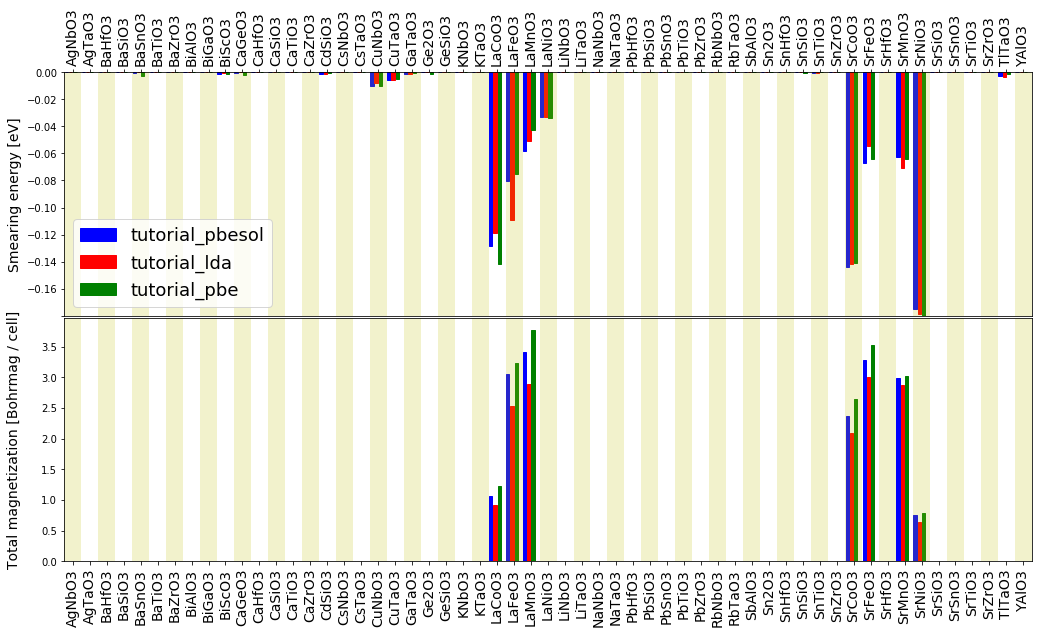

In [14]:
plot_results(res)